# Building a Content-Based Recommendation Sytem with Lyrics #
Most recommendation system used by services such as Spotify, Netflix, and Youtube take a hybrid approach of both content-based and collaborative filtering to build their recommendation algorithms. Here, we aim to built a prototype of a content-based recommendation system, using lyrics to measure the similarity to two songs. We introduce two methods: tf-idf and Doc2Vec, and visualize the result that they output. 

First, some data preprocessing. Luckily, someone already did that for us [here](https://github.com/areevesman/lyric-embeddings/blob/master/train_example.ipynb)! We are creating a dataframe object with the columns MSD id, "cleaned text" referring to the bag of words without stop words, artist, and title.

In [1]:
import pandas as pd
import numpy as np

In [2]:
from stop_words import get_stop_words
stop_words = get_stop_words('english')

In [3]:
REMOVE_STOPWORDS = True

In [4]:
with open('data/mxm_dataset_train.txt','r') as f:
    lines = f.readlines()
    words = lines[17].replace('%','').split(',')
    all_songs_dict = dict()
    for i,l in list(enumerate(lines))[18:]:
        song_info = l.split(',')
        MSDID = song_info[0]
        song_bow = [x.split(':') for x in song_info[2:]]
        song_dict = {}
        for word, word_count in song_bow:
            song_dict[int(word)] = int(word_count.replace('\n',''))
        word_lists = [[words[word-1]]*song_dict[word] for word in song_dict.keys()]
        song = [word for word_list in word_lists for word in word_list]
        if REMOVE_STOPWORDS:
            song = [w for w in song if w not in stop_words]
        all_songs_dict[str(MSDID)] = ' '.join(song).replace('\n','')

In [5]:
all_song_meta_dict = dict()
with open('data/mxm_779k_matches.txt','r') as f:
    lines = f.readlines()
    for i in range(18, len(lines)):
        line = lines[i].split('<SEP>')
        MSDID = line[0]
        artist = line[1]
        title = line[2]
        all_song_meta_dict[str(MSDID)] = {'artist': artist, 'title': title}

In [6]:
d = {
    'MSDID': list(all_songs_dict.keys()),
    'cleaned_text': [all_songs_dict[x] for x in all_songs_dict.keys()]
    }
msdid_df = pd.DataFrame.from_dict(d)
print(msdid_df.shape)
msdid_df.head()

(210519, 2)


,MSDID,cleaned_text
0,TRAAAAV128F421A322,will will like like de got seem someon underst...
1,TRAAABD128F429CF47,know know know know know time time time can la...
2,TRAAAED128E0783FAB,will will will will will will will will will w...
3,TRAAAEF128F4273421,know can got got got feel let eye world right ...
4,TRAAAEW128F42930C0,like take wo someth stay burn burn burn burn b...


In [7]:
d = {
    'MSDID': msdid_df['MSDID'],
    'artist': [all_song_meta_dict[x]['artist'] for x in msdid_df['MSDID']],
    'title': [all_song_meta_dict[x]['title'] for x in msdid_df['MSDID']]
    }
meta_df = pd.DataFrame.from_dict(d)
print(meta_df.shape)
meta_df.head()

(210519, 3)


,MSDID,artist,title
0,TRAAAAV128F421A322,Western Addiction,A Poor Recipe For Civic Cohesion
1,TRAAABD128F429CF47,The Box Tops,Soul Deep
2,TRAAAED128E0783FAB,Jamie Cullum,It's About Time
3,TRAAAEF128F4273421,Adam Ant,Something Girls
4,TRAAAEW128F42930C0,Broken Spindles,Burn My Body (Album Version)


In [119]:
full_df_ = pd.merge(msdid_df, meta_df, on='MSDID', how='left')
full_df_.head()

,MSDID,cleaned_text,artist,title
0,TRAAAAV128F421A322,will will like like de got seem someon underst...,Western Addiction,A Poor Recipe For Civic Cohesion
1,TRAAABD128F429CF47,know know know know know time time time can la...,The Box Tops,Soul Deep
2,TRAAAED128E0783FAB,will will will will will will will will will w...,Jamie Cullum,It's About Time
3,TRAAAEF128F4273421,know can got got got feel let eye world right ...,Adam Ant,Something Girls
4,TRAAAEW128F42930C0,like take wo someth stay burn burn burn burn b...,Broken Spindles,Burn My Body (Album Version)


In [120]:
# full dataset, MSDID, bag of words, artist, title
full_df = full_df_.copy()

### Method 1: tf-idf ###
The idea is to transform documents into vectors, with which we will be able to compare the similarity between two songs by finding the cosine similarity between these two vectors. The base code has been provided by this [link](https://github.com/ugis22/music_recommender) and has been modified to fit our needs.

In [343]:
from sklearn.feature_extraction.text import TfidfVectorizer # transforms documents into vectors
from sklearn.metrics.pairwise import cosine_similarity      # similarity measures

In [344]:
random_sample_df = full_df.sample(n=10000).reset_index(drop=True)

In [345]:
random_sample_df.head()

,MSDID,cleaned_text,artist,title
0,TRFMAQU128E0789AEA,know just just like now now now come go oh oh ...,Shelby Lynne,Where Am I Now
1,TRWCHTI128F145622A,will love love love love love love love love l...,The Moody Blues,Nights In White Satin
2,TRSROQZ128F428873F,will will love know know know just just like n...,Tyrese,On Top Of Me
3,TRFVQYK128F9350A56,will will will will will love love love know k...,Avalon,For Freedom (High Key-Premiere Performance Plu...
4,TRDFNMR128F92C909F,know know know know know see say say say heart...,Midnight Oil,Sometimes


In [374]:
tfidf = TfidfVectorizer(analyzer='word')
tfidf_matrix = tfidf.fit_transform(random_sample_df['cleaned_text'])
cosine_similarities = cosine_similarity(tfidf_matrix) 

for i in range(cosine_similarities.shape[0]):
    cosine_similarities[i, i] = 0

Now, we have a similarity matrix, and we can apply the same method as the collaborative filtering to make recommendations. For a hybrid approach, we add the similarity measures here to hold some weight.

### Comparing similarities from tf-idf ###
Sadly, we don't have many (if any) overlap between the taste profile subset and musicXmatch dataset so we aren't able to determine the accuracy of this recommendation system. However, what we can do is to examine these similarity values and draw conclusions based on the human understanding of "similar" music. While this doesn't show us that this method is accurate enough to be implemented, we can tell whether the values are better than random (basically not utter trash). 

In [375]:
full_df.artist.value_counts()[:10]

Carly Simon          136
Bruce Springsteen    131
Frank Sinatra        117
Johnny Cash          115
The Cure             113
Neil Diamond         112
Joan Baez            111
Less Than Jake       111
The Hollies          110
Elvis Presley        110
Name: artist, dtype: int64

From the above, we can see which artists have the most number of songs. I choose to compare The Cure and Bruce Springsteen since they seem like they would be very different artists (the former is a gothic rock band and the latter, a country artist).

In [376]:
cure_df = full_df.loc[full_df["artist"] == "The Cure"]
cure_df.head()

,MSDID,cleaned_text,artist,title
4658,TRAOJZC128F14932D5,love love love love love love know know know t...,The Cure,Lost
5628,TRARFVY128F93086DE,will will will will love love know know like l...,The Cure,Lullaby
7794,TRAYCIH128E07890B9,will will will will will will will will will w...,The Cure,Doubt
13221,TRBPMYB128F147CD47,will will will will will will will will know k...,The Cure,Six Different Ways
14035,TRBSDQB128F4234081,will will will know just just like now now tim...,The Cure,Cut Here


In [377]:
bruce_df = full_df.loc[full_df["artist"] == "Bruce Springsteen"]
bruce_df.head()

,MSDID,cleaned_text,artist,title
1405,TRAEEUX128F425E0E6,will will will will will will will will will w...,Bruce Springsteen,Magic
1422,TRAEGDZ128F42672C1,will will will love love know know know just j...,Bruce Springsteen,Roll Of The Dice
3456,TRAKQQD128F932A358,will time come come come one way ca day day da...,Bruce Springsteen,Waitin' On A Sunny Day
4349,TRANMSC128F426AE28,know like now now now now can come go go go ge...,Bruce Springsteen,My Best Was Never Good Enough
6370,TRATMLJ128F427ABCB,one one one one one one one one get see want b...,Bruce Springsteen,One Step Up


In [378]:
merged_df = pd.concat([cure_df, bruce_df], axis=0, join='inner')
merged_df.reset_index(drop=True, inplace=True)
merged_df

,MSDID,cleaned_text,artist,title
0,TRAOJZC128F14932D5,love love love love love love know know know t...,The Cure,Lost
1,TRARFVY128F93086DE,will will will will love love know know like l...,The Cure,Lullaby
2,TRAYCIH128E07890B9,will will will will will will will will will w...,The Cure,Doubt
3,TRBPMYB128F147CD47,will will will will will will will will know k...,The Cure,Six Different Ways
4,TRBSDQB128F4234081,will will will know just just like now now tim...,The Cure,Cut Here
...,...,...,...,...
239,TRYIUSU128F42670A9,will just now time time got never feel feel fe...,Bruce Springsteen,Out In The Street
240,TRYRCXK128F932A7E9,will will will will will love love love know k...,Bruce Springsteen,Born To Run
241,TRYSUOR128F427BD18,will just like now now now can get feel want w...,Bruce Springsteen,No Surrender
242,TRZQTSM128F9328120,know can one got feel night night night thing ...,Bruce Springsteen,Gave It A Name


In [379]:
# number of songs for each artist
n, m = len(cure_df), len(bruce_df)

In [380]:
tfidf = TfidfVectorizer(analyzer='word')
t_matrix = tfidf.fit_transform(merged_df['cleaned_text'])
cos_t = cosine_similarity(t_matrix)

for i in range(n + m):
    cos_t[i, i] = 0

In [381]:
cure_vs_cure   = cos_t[:n, :n]
cure_vs_bruce  = cos_t[:n, n:] # == [n:n+m, :n], since cos sim is symmetric
bruce_vs_bruce = cos_t[n:, n:]

In [382]:
print("Avg cos sim, two The Cure songs:             ", np.mean(cure_vs_cure))
print("Avg cos sim, The Cure and Bruce Springsteen: ", np.mean(cure_vs_bruce))
print("Avg cos sim, two Bruce Springsteen songs:    ", np.mean(bruce_vs_bruce))

Avg cos sim, two The Cure songs:              0.059792039287589374
Avg cos sim, The Cure and Bruce Springsteen:  0.04365555043150838
Avg cos sim, two Bruce Springsteen songs:     0.056485031215891275


We see here that two songs from the same artists are generally more similar than other artists, suggesting that this method can predict similarity between two songs to at least some extent. A benefit to this recommendtion system is that there exists no bias towards popularity, allowing users to discover songs they might not otherwise run across. However, limitations do exist in this recommendaiton system. It only really allows a user to listen to the same type of songs that they are already like. More information can be found in the [orginial article](https://towardsdatascience.com/the-abc-of-building-a-music-recommender-system-part-i-230e99da9cad).

### Method 2: Doc2Vec ###
Again, we turn documents into vectors, then compute the cosine similarity between two songs. The original code can be found [here](https://github.com/areevesman/lyric-embeddings/blob/master/train_example.ipynb).

In [383]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk import word_tokenize

In [384]:
data = merged_df['cleaned_text'].tolist()
train_corpus = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in list(enumerate(data))]

In [385]:
model = Doc2Vec(vector_size=50, min_count=1, epochs=10, dm=0)
model.build_vocab(train_corpus)

In [386]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [387]:
# useful for larger datasets
# model.save('trained_model_example')
# model = Doc2Vec.load('trained_model_example')

In [388]:
d_matrix = np.array([model.dv[f'{i}'] for i in range(len(merged_df))])

In [389]:
# create a cosine similarity matrix:
cos_d = cosine_similarity(d_matrix)
for i in range(n + m):
    cos_d[i, i] = 0

In [390]:
cure_vs_cure   = cos_d[:n, :n]
cure_vs_bruce  = cos_d[:n, n:] # == [n:n+m, :n], since cos sim is symmetric
bruce_vs_bruce = cos_d[n:, n:]

In [391]:
print("Avg cos sim, two The Cure songs:             ", np.mean(cure_vs_cure))
print("Avg cos sim, The Cure and Bruce Springsteen: ", np.mean(cure_vs_bruce))
print("Avg cos sim, two Bruce Springsteen songs:    ", np.mean(bruce_vs_bruce))

Avg cos sim, two The Cure songs:              0.94109404
Avg cos sim, The Cure and Bruce Springsteen:  0.94518346
Avg cos sim, two Bruce Springsteen songs:     0.9423327


Here, it seems as the differences are less apparent between in doc2vec compared to td-idf in this specific example. Here, there is no significant difference the cure and Bruce Springsteen songs.

### Visualizing tf-idf and doc2vec with t-SNE ###
In both methods implemented above, we first transform lyrics into vectors, then compute the similarity between two songs by computing the cosine similarity between the two vectors. In the examples above, lyrics are converted into a 1721-dimensional vector and 50-dimensional vector by the tf-idf and doc2vec algorithm, respectively. Thus, we utilise a dimension-reduction technique called [t-Distributed Stochastic Neighbor Embedding (t-SNE)](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) to visualize the distances between vectors in a lower dimension. This dimension-reduction technique is a probabilistic method, which works by preserving the local relationships in the higher dimension, estimating a probability distribtuion, and recreates these in a lower dimension. 

A small note. To reduce the dimension, we use t-SNE and not PCA. The difference between them is that 1) t-SNe is probabilistic while PCA is not 2) t-SNE perserve local relationships, while PCA preserves larger distances. In this case, t-SNE is more favourable, as we want to see how close together two songs are. Information found [here](https://medium.com/analytics-vidhya/pca-vs-t-sne-17bcd882bf3d#:~:text=t%2DSNE(T%2D%20distributed%20Stochastic%20Neighbor%20Embedding)%3A&text=One%20of%20the%20most%20major,large%20pairwise%20distance%20maximize%20variance.&text=It%20takes%20a%20set%20of,it%20into%20low%20dimensional%20data.).

In [392]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from scipy.sparse import csc_matrix

In [400]:
t_df = pd.DataFrame()

dim_t = t_matrix.shape[1]
for i in range(dim_t):
    t_df[i] = t_matrix.getcol(i).transpose().A[0]
t_df

,0,1,2,3,4,5,6,7,8,9,...,2142,2143,2144,2145,2146,2147,2148,2149,2150,2151
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.221784,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074389,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.082308,0.0,0.0,0.0,0.0,0.053933,0.0,0.0,0.0,0.0
241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.083954,0.0,0.0,0.0,0.0
242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [401]:
d_df = pd.DataFrame()
dim_d = d_matrix.shape[1]
for i in range(dim_d):
    d_df[i] = d_matrix[:,i]
d_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.390311,-0.250433,-0.115222,0.200240,-0.057030,-0.184226,-0.154366,-0.209139,-0.560914,-0.083350,...,0.022743,0.281792,-0.386048,-0.186973,0.249394,-0.036394,-0.045218,-0.075771,0.121177,-0.274577
1,-0.418832,-0.161260,-0.128897,0.064967,0.005640,-0.148616,-0.006792,-0.175164,-0.474373,-0.072238,...,0.005649,0.445297,-0.394447,-0.185966,0.170836,0.032434,-0.050835,-0.151111,0.062553,-0.207230
2,-0.553152,-0.242255,-0.190411,0.122594,-0.047196,-0.248950,-0.003176,-0.109887,-0.438786,-0.075358,...,0.104396,0.447094,-0.353781,-0.326094,0.203736,0.006877,-0.041003,-0.064378,-0.015157,-0.293558
3,-0.375079,-0.144970,-0.019743,0.088632,-0.078533,-0.177449,0.006396,-0.159663,-0.465426,-0.113026,...,0.027518,0.420025,-0.361075,-0.055009,0.157794,0.051305,-0.040561,-0.132340,0.032212,-0.188366
4,-0.483031,-0.189645,-0.076160,0.080599,0.071790,-0.244702,0.018187,-0.228781,-0.464614,-0.068324,...,0.106662,0.508657,-0.297038,-0.151891,0.190282,-0.032344,-0.060951,-0.098777,-0.014156,-0.273947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,-0.491127,-0.033024,0.067444,0.385521,0.077778,-0.267579,0.001057,-0.321102,-0.400751,-0.133289,...,0.053260,0.476531,-0.379410,-0.039824,0.195780,0.101491,0.043430,-0.190933,-0.162757,-0.044085
240,-0.423049,-0.105441,0.067703,0.294953,-0.040962,-0.227638,0.004222,-0.264515,-0.438203,-0.153117,...,0.063735,0.431863,-0.449977,-0.027869,0.168838,0.082509,0.044633,-0.161802,-0.014915,-0.138565
241,-0.431233,-0.112154,0.008432,0.191623,-0.036265,-0.197748,0.033211,-0.188095,-0.464196,-0.123723,...,0.018790,0.406633,-0.412778,-0.090993,0.180435,0.047055,-0.065185,-0.191008,0.026823,-0.212158
242,-0.395186,-0.174615,-0.027451,0.164196,-0.015404,-0.176191,0.013259,-0.205471,-0.458783,-0.089730,...,0.078952,0.450971,-0.354982,-0.040549,0.099116,0.016158,-0.017804,-0.136442,0.004903,-0.178990


In [410]:
n_dim = 2

pipeline = Pipeline([('scaling', StandardScaler()), ('tsne', TSNE(n_components=n_dim, perplexity=30, random_state=42))])
song_embedding = pipeline.fit_transform(t_df)
# tsne = TSNE(n_components=n, perplexity=30, random_state=42)
# song_embedding = tsne.fit_transform(song_df)
tsne_df = pd.DataFrame(data = song_embedding, columns = list(range(n_dim)))
tsne_df['title'] = merged_df['title']
tsne_df['artist'] = merged_df['artist']

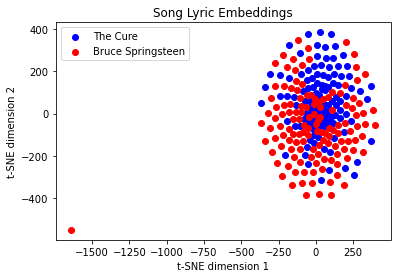

In [411]:
plt.title("Song Lyric Embeddings")
plt.scatter(tsne_df[0][:n], tsne_df[1][:n], color = "b", label = "The Cure")
plt.scatter(tsne_df[0][n:], tsne_df[1][n:], color = "r", label = "Bruce Springsteen")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.legend()
plt.show()

In [412]:
# let's get rid of the outlier
tsne_df.loc[tsne_df[0] < -1000]

,0,1,title,artist
184,-1642.335205,-552.515015,Last To Die,Bruce Springsteen


In [413]:
tsne_df.drop(184, inplace=True)

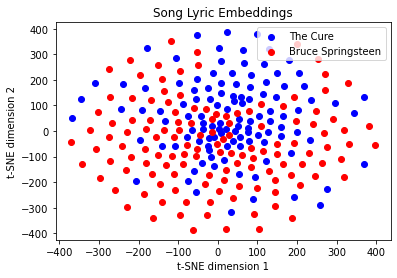

In [414]:
plt.title("Song Lyric Embeddings")
plt.scatter(tsne_df[0][:n], tsne_df[1][:n], color = "b", label = "The Cure")
plt.scatter(tsne_df[0][n:], tsne_df[1][n:], color = "r", label = "Bruce Springsteen")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.legend()
plt.show()

Here, it does not really look like there is a big difference between the two artists. 

In [415]:
n_dim = 2

pipeline = Pipeline([('scaling', StandardScaler()), ('tsne', TSNE(n_components=n_dim, perplexity=30, random_state=42))])
song_embedding = pipeline.fit_transform(d_df)
# tsne = TSNE(n_components=n, perplexity=30, random_state=42)
# song_embedding = tsne.fit_transform(song_df)
tsne_df = pd.DataFrame(data = song_embedding, columns = list(range(n_dim)))
tsne_df['title'] = merged_df['title']
tsne_df['artist'] = merged_df['artist']

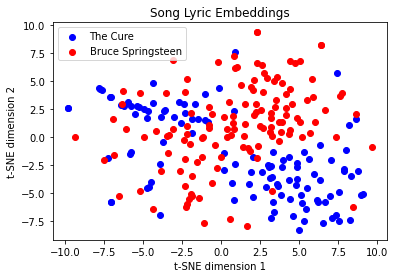

In [417]:
plt.title("Song Lyric Embeddings")
plt.scatter(tsne_df[0][:n], tsne_df[1][:n], color = "b", label = "The Cure")
plt.scatter(tsne_df[0][n:], tsne_df[1][n:], color = "r", label = "Bruce Springsteen")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.legend()
plt.show()

Here, it also does not realy suggest much, although there are clusters here and there, most notably at the bottom right of graph of almost purely the Cure. Note that in the [article](https://towardsdatascience.com/lyric-based-song-recommendation-with-doc2vec-embeddings-and-spotifys-api-5a61c39f1ce2), they plotted more examples and showed how Doc2Vec is capable of.

Overall, both these methods teach us something about the similarity between two songs. In reality, lyrics are only one piece of the puzzle, and building a hybrid recommendation system requires more from content-based side rather than just lyrics. However, we were succesful in exploring some areas of Natural Language Processing that helps us build our final product.